# Step 0. 필요한 라이브러리 import

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

import time
import re
import os
import io

from tqdm import tqdm    # tqdm
import random

from konlpy.tag import Mecab
mecab = Mecab()

# Step 1. 데이터 다운

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)에서 korean-english-park.train.tar.gz 다운후 사용

In [2]:
with open("korean-english-park.train.ko.txt", "r") as f:
    kor = f.read().splitlines()
with open("korean-english-park.train.en.txt", "r") as f:
    eng = f.read().splitlines()

In [3]:
# 데이터셋 확인
print(kor[0])
print(eng[0])

개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
Much of personal computing is about "can you top this?"


데이터프레임을 사용해 한-영 병렬 데이터로 변경

In [4]:
data = pd.DataFrame()
data['kor'] = kor
data['eng'] = eng

data

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


# Step 2. 데이터 정제

1. 중복 제거

In [5]:
data.duplicated('kor').sum()

16532

In [6]:
data.duplicated('eng').sum()

18525

In [7]:
data.drop_duplicates('kor', inplace=True)

In [8]:
data.drop_duplicates('eng', inplace=True)

In [9]:
data.duplicated('kor').sum()

0

In [10]:
data.duplicated('eng').sum()

0

In [11]:
cleaned_corpus = data
# 인덱스 재정의
cleaned_corpus.reset_index(drop=True, inplace=True)

cleaned_corpus

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
74844,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
74845,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
74846,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
74847,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


2. 정규화

In [12]:
def preprocess_sentence(sentence):
    
    # 소문자로 치환, 앞뒤 공백 제거
    sentence = sentence.lower().strip()
    # 단어와 구두점(punctuation) 사이 뷴리
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 다중 공백 -> 단일 공백
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    
    return sentence

In [13]:
clean_kor = []
clean_eng = []

for x in cleaned_corpus['kor']:
    clean_kor.append(preprocess_sentence(x))
    
for x in cleaned_corpus['eng']:
    clean_eng.append(preprocess_sentence(x))

cleaned_corpus['kor'] = clean_kor
cleaned_corpus['eng'] = clean_eng

cleaned_corpus

,kor,eng
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,much of personal computing is about can you to...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"like all optical mice , but it also doesn t ne..."
3,"79 . 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔...,intelligence officials have revealed a spate o...
...,...,...
74844,우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,we are hoping to seize material evidence to ...
74845,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했...,"on monday , police secured statements from s..."
74846,그러나 불충분한 증거 확보로 수사에 어려움이 있다 .,but the lack of material evidence is making it...
74847,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다 .,kim and his son both deny the allegations .


3. 토큰화

- 영어
    - split() 사용
- 한국어
    - mecab 사용

In [14]:
token_corpus = cleaned_corpus

kor_token_corpus = []
eng_token_corpus = []

for x in token_corpus['kor']:
    kor_token_corpus.append(mecab.morphs(x))
    
for x in token_corpus['eng']:
    x = '<start> ' + x
    x += ' <end>'

    eng_token_corpus.append(x.split())
    
token_corpus['kor'] = kor_token_corpus
token_corpus['eng'] = eng_token_corpus

token_corpus

,kor,eng
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, much, of, personal, computing, is, a..."
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ..."
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[<start>, like, all, optical, mice, ,, but, it..."
3,"[79, ., 95, 달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허...","[<start>, uses, gyroscopic, sensors, to, contr..."
4,"[정보, 관리, 들, 은, 동남, 아시아, 에서, 의, 선박, 들, 에, 대한, 많...","[<start>, intelligence, officials, have, revea..."
...,...,...
74844,"[우리, 는, 3, 월, 8, 일, 김승연, 회장, 과, 그, 의, 아들, 이, 보...","[<start>, we, are, hoping, to, seize, material..."
74845,"[월요일, 술집, 종업원, 6, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, ...","[<start>, on, monday, ,, police, secured, stat..."
74846,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다...","[<start>, but, the, lack, of, material, eviden..."
74847,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, kim, and, his, son, both, deny, the,..."


토큰의 길이가 40 이하인 데이터를 선별

In [15]:
max_len=40

token_corpus = token_corpus[token_corpus["kor"].apply(lambda x: len(x) <= max_len) &
              token_corpus["eng"].apply(lambda x: len(x) <= max_len)]
# 인덱스 재정의
token_corpus.reset_index(drop=True, inplace=True)

token_corpus

,kor,eng
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, much, of, personal, computing, is, a..."
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ..."
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[<start>, like, all, optical, mice, ,, but, it..."
3,"[결정, 적, 인, 순간, 에, 그, 들, 의, 능력, 을, 증가, 시켜, 줄, 그...","[<start>, something, that, will, boost, their,..."
4,"[연구가, 들, 이, 이미, 커피, 대체, 품, 으로서, 음식, 대용, 과자, 나,...","[<start>, researchers, are, already, exploring..."
...,...,...
57455,"[우리, 는, 3, 월, 8, 일, 김승연, 회장, 과, 그, 의, 아들, 이, 보...","[<start>, we, are, hoping, to, seize, material..."
57456,"[월요일, 술집, 종업원, 6, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, ...","[<start>, on, monday, ,, police, secured, stat..."
57457,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다...","[<start>, but, the, lack, of, material, eviden..."
57458,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, kim, and, his, son, both, deny, the,..."


In [16]:
kor_corpus = []
eng_corpus = []

for x in token_corpus['kor']:  
    kor_corpus.append(x)
    
for x in token_corpus['eng']:
    eng_corpus.append(x)

# Step 3. 데이터 토큰화

In [17]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [18]:
enc, enc_tokenizer = tokenize(kor_corpus)
dec, dec_tokenizer = tokenize(eng_corpus)

print("Kor Vocab Size:", len(enc_tokenizer.index_word))
print("Eng Vocab Size:", len(dec_tokenizer.index_word))

Kor Vocab Size: 43266
Eng Vocab Size: 39097


# Step 4. 모델 설계

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [22]:
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# Step 5. 훈련하기

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [24]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [54]:
def evaluate(sentence_list, encoder, decoder):
    results = []
    attentions = []
    sentences = []
    
    for sentence in sentence_list:
        attention = np.zeros((dec.shape[-1], enc.shape[-1]))

        sentence = preprocess_sentence(sentence)
        sentence = mecab.morphs(sentence)
        inputs = enc_tokenizer.texts_to_sequences([sentence])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=enc.shape[-1],
                                                               padding='post')

        result = ''

        enc_out = encoder(inputs)

        dec_hidden = enc_out[:, -1]
        dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

        for t in range(dec.shape[-1]):
            predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                 dec_hidden,
                                                                 enc_out)

            attention_weights = tf.reshape(attention_weights, (-1, ))
            attention[t] = attention_weights.numpy()

            predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

            result += dec_tokenizer.index_word[predicted_id] + ' '

            if dec_tokenizer.index_word[predicted_id] == '<end>':
                break

            dec_input = tf.expand_dims([predicted_id], 0)

        sentences.append(sentence)
        results.append(result.strip())
        attentions.append(attention)

    return results, sentences, attentions

In [26]:
EPOCHS = 10
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) 
    
    test_sentence = [
        '오바마는 대통령이다.',
        '시민들은 도시 속에 산다.',
        '커피는 필요 없다.',
        '일곱 명의 사망자가 발생했다.'
    ]
    
    results, sentences, attentions = evaluate(test_sentence, encoder, decoder)

    for x in range(len(test_sentence)):
        print(f'E{x+1})', test_sentence[x])
        print(f'E{x+1})', results[x])

Epoch  1: 100%|██████████| 898/898 [10:45<00:00,  1.39it/s, Loss 4.0495] 


E1) 오바마는 대통령이다.
E1) the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
E2) 시민들은 도시 속에 산다.
E2) the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be
E3) 커피는 필요 없다.
E3) the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be
E4) 일곱 명의 사망자가 발생했다.
E4) the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be


Epoch  2: 100%|██████████| 898/898 [09:41<00:00,  1.54it/s, Loss 3.6401]


E1) 오바마는 대통령이다.
E1) the . <end>
E2) 시민들은 도시 속에 산다.
E2) the . <end>
E3) 커피는 필요 없다.
E3) the . <end>
E4) 일곱 명의 사망자가 발생했다.
E4) the . <end>


Epoch  3: 100%|██████████| 898/898 [09:21<00:00,  1.60it/s, Loss 3.5026]


E1) 오바마는 대통령이다.
E1) the first year . <end>
E2) 시민들은 도시 속에 산다.
E2) the government s . <end>
E3) 커피는 필요 없다.
E3) the government s . <end>
E4) 일곱 명의 사망자가 발생했다.
E4) the first year . <end>


Epoch  4: 100%|██████████| 898/898 [09:24<00:00,  1.59it/s, Loss 3.3793]


E1) 오바마는 대통령이다.
E1) the few . <end>
E2) 시민들은 도시 속에 산다.
E2) the government s . <end>
E3) 커피는 필요 없다.
E3) the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
E4) 일곱 명의 사망자가 발생했다.
E4) the world s . <end>


Epoch  5: 100%|██████████| 898/898 [09:25<00:00,  1.59it/s, Loss 3.3024]


E1) 오바마는 대통령이다.
E1) the first year . <end>
E2) 시민들은 도시 속에 산다.
E2) the first time . <end>
E3) 커피는 필요 없다.
E3) the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to
E4) 일곱 명의 사망자가 발생했다.
E4) the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to


Epoch  6: 100%|██████████| 898/898 [09:26<00:00,  1.58it/s, Loss 3.2355]


E1) 오바마는 대통령이다.
E1) the first time . <end>
E2) 시민들은 도시 속에 산다.
E2) the first time . <end>
E3) 커피는 필요 없다.
E3) the first time . <end>
E4) 일곱 명의 사망자가 발생했다.
E4) the first time in the first time in the first time in the first time in the first time in the first time in the first time in the first time in the first time in the first time in


Epoch  7: 100%|██████████| 898/898 [09:28<00:00,  1.58it/s, Loss 3.1578]


E1) 오바마는 대통령이다.
E1) the latest . <end>
E2) 시민들은 도시 속에 산다.
E2) the first time in the first time in the first time in the first time in the first time in the first time in the first time in the first time in the first time in the first time in
E3) 커피는 필요 없다.
E3) the first time to be a new york , and the first time to be a new york , and the first time to be a new york , and the first time to be a new york , and
E4) 일곱 명의 사망자가 발생했다.
E4) the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time ,


Epoch  8: 100%|██████████| 898/898 [09:29<00:00,  1.58it/s, Loss 3.0755]


E1) 오바마는 대통령이다.
E1) the white house of the white house of the white house of the white house of the white house of the white house of the white house of the white house of the white house of the white house of
E2) 시민들은 도시 속에 산다.
E2) the white house , the white house of the white house , the white house of the white house , the white house of the white house , the white house of the white house , the white house of
E3) 커피는 필요 없다.
E3) the ap s first time . <end>
E4) 일곱 명의 사망자가 발생했다.
E4) the u . s . <end>


Epoch  9: 100%|██████████| 898/898 [09:30<00:00,  1.57it/s, Loss 3.0068]


E1) 오바마는 대통령이다.
E1) the dow jones , the dow jones , the dow jones , the dow jones , the dow jones , the dow jones , the dow jones , the dow jones , the dow jones , the dow jones ,
E2) 시민들은 도시 속에 산다.
E2) the first time . <end>
E3) 커피는 필요 없다.
E3) the economy . <end>
E4) 일곱 명의 사망자가 발생했다.
E4) the u . s . <end>


Epoch 10: 100%|██████████| 898/898 [09:31<00:00,  1.57it/s, Loss 2.9356]


E1) 오바마는 대통령이다.
E1) the white house , and the white house , and the white house , and the white house , and the white house , and the white house , and the white house , and the white house , and
E2) 시민들은 도시 속에 산다.
E2) the ap s . <end>
E3) 커피는 필요 없다.
E3) the dow industrials down . <end>
E4) 일곱 명의 사망자가 발생했다.
E4) the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government ,


시각화

In [57]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    results, sentences, attentions = evaluate(sentence, encoder, decoder)

    for x in range(len(results)):      
        print('Input: %s' % (sentences[x]))
        print('Predicted translation: {}'.format(results[x]))

        attention = attentions[x][:len(results[x].split()), :len(sentences[x])]
        plot_attention(attention, sentences[x], results[x].split(' '))

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the white house , and the white house , and the white house , and the white house , and the white house , and the white house , and the white house , and the white house , and


/tmp/ipykernel_154/4110921301.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_154/4110921301.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


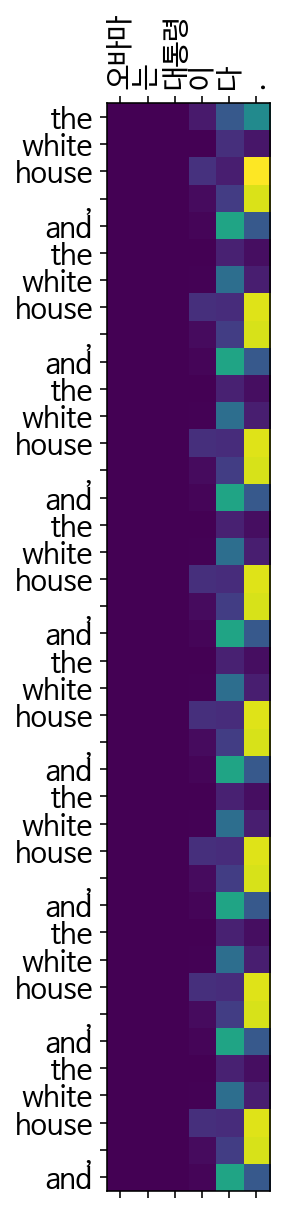

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the ap s . <end>


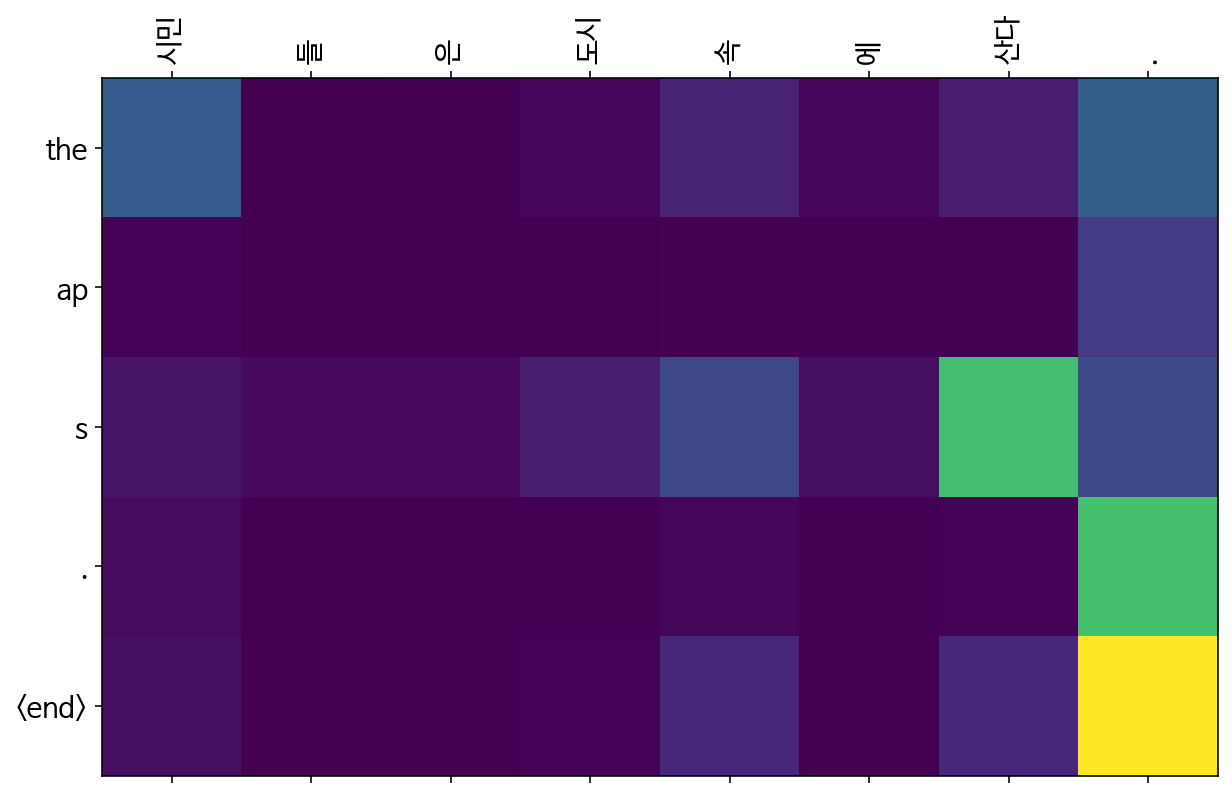

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the dow industrials down . <end>


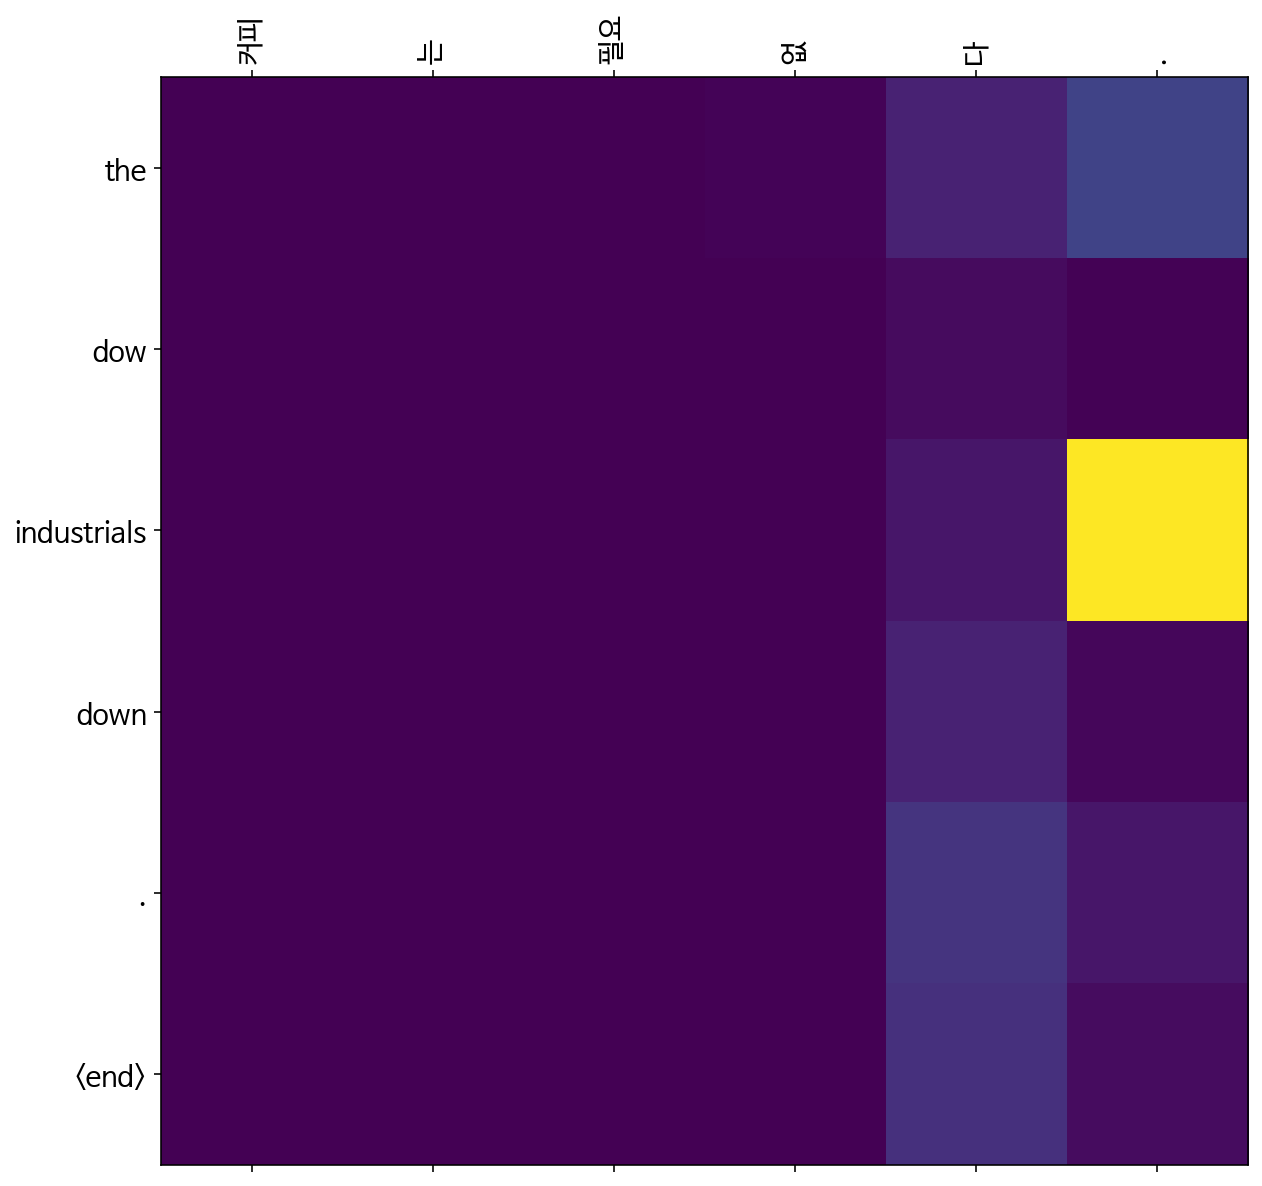

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government , the iraqi government ,


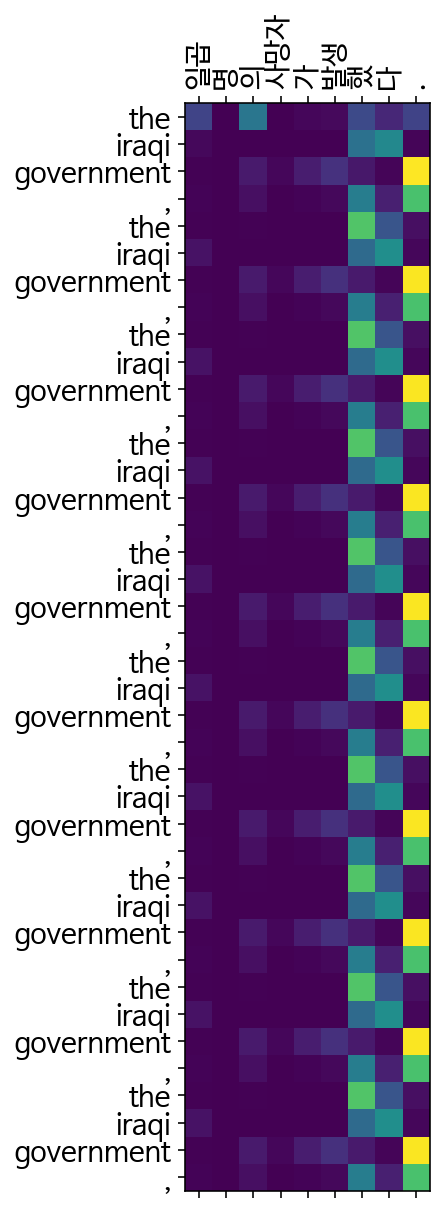

In [58]:
%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

test_sentence = [
        '오바마는 대통령이다.',
        '시민들은 도시 속에 산다.',
        '커피는 필요 없다.',
        '일곱 명의 사망자가 발생했다.'
    ]

translate(test_sentence, encoder, decoder)

# 회고

- BahdanauAttention을 사용한 Seq2seq를 만들어 한 - 영 번역기를 만들어 보면서 Attention의 개념을 조금 더 이해 하게 된거 같다.
- 이번 Seq2seq 모델 결과를 보다보니 왜 대세가 트랜스포머인지 명확하게 알 수 있었음!
- 여기서 성능(train loss 감소)을 끌어올리려면 적어도 30 ~ 40 epoch 정도의 훈련이 추가로 필요해 보임!!